### Load Dataset

In [1]:
import deeply.datasets as dd

In [2]:
montgomery, info = dd.load("montgomery", with_info = True)

### Prepare Data

In [3]:
import os, os.path as osp
import tqdm.notebook as tq
import random

import numpy as np
import imgaug.augmenters as iaa
import imageio

import matplotlib.pyplot as pplt

from deeply.util.system import remove, makedirs
from deeply.util.string import get_random_str

In [4]:
size_image = (512, 512, 1)

In [5]:
dir_base   = "data"
dir_images = osp.join(dir_base, "images")
dir_masks  = osp.join(dir_base, "masks")

In [6]:
sequential = iaa.Sequential([
    iaa.Resize({ "width": size_image[0], "height": size_image[1] }),
#     iaa.CLAHE()
])

In [7]:
if osp.exists(dir_base):
    remove(dir_base, recursive = True)

makedirs(dir_images, exist_ok = True)
makedirs(dir_masks,  exist_ok = True)

for batch in tq.tqdm(montgomery["train"].batch(1)):
    image = sequential(images = np.asarray(batch["image"]))
    mask  = sequential(images = np.asarray(batch["mask"]))
    
    for i, _ in enumerate(image):
        name = "%s.jpg" % get_random_str()
        
        imageio.imwrite(osp.join(dir_images, name), image[i])
        imageio.imwrite(osp.join(dir_masks,  name), mask[i])

  0%|          | 0/138 [00:00<?, ?it/s]

### Build Model

In [8]:
batch_size = 32
n_classes  = 1

In [9]:
%load_ext autoreload
%autoreload

In [10]:
from deeply.model.unet import UNet
from deeply.generators import ImageMaskGenerator
from deeply.losses     import dice_loss

In [11]:
unet = UNet(
    x = size_image[0],
    y = size_image[1],
    channels  = size_image[2],
    n_classes = n_classes
#     dropout_rate = 0
)

In [12]:
unet_img_out_shape = unet.output_shape[1:-1]

In [13]:
unet.compile(loss = dice_loss)

In [14]:
generator = ImageMaskGenerator(dir_images, dir_masks, mode = "grayscale",
                               image_size = size_image[0:2],
                               mask_size  = unet_img_out_shape, batch_size = batch_size)

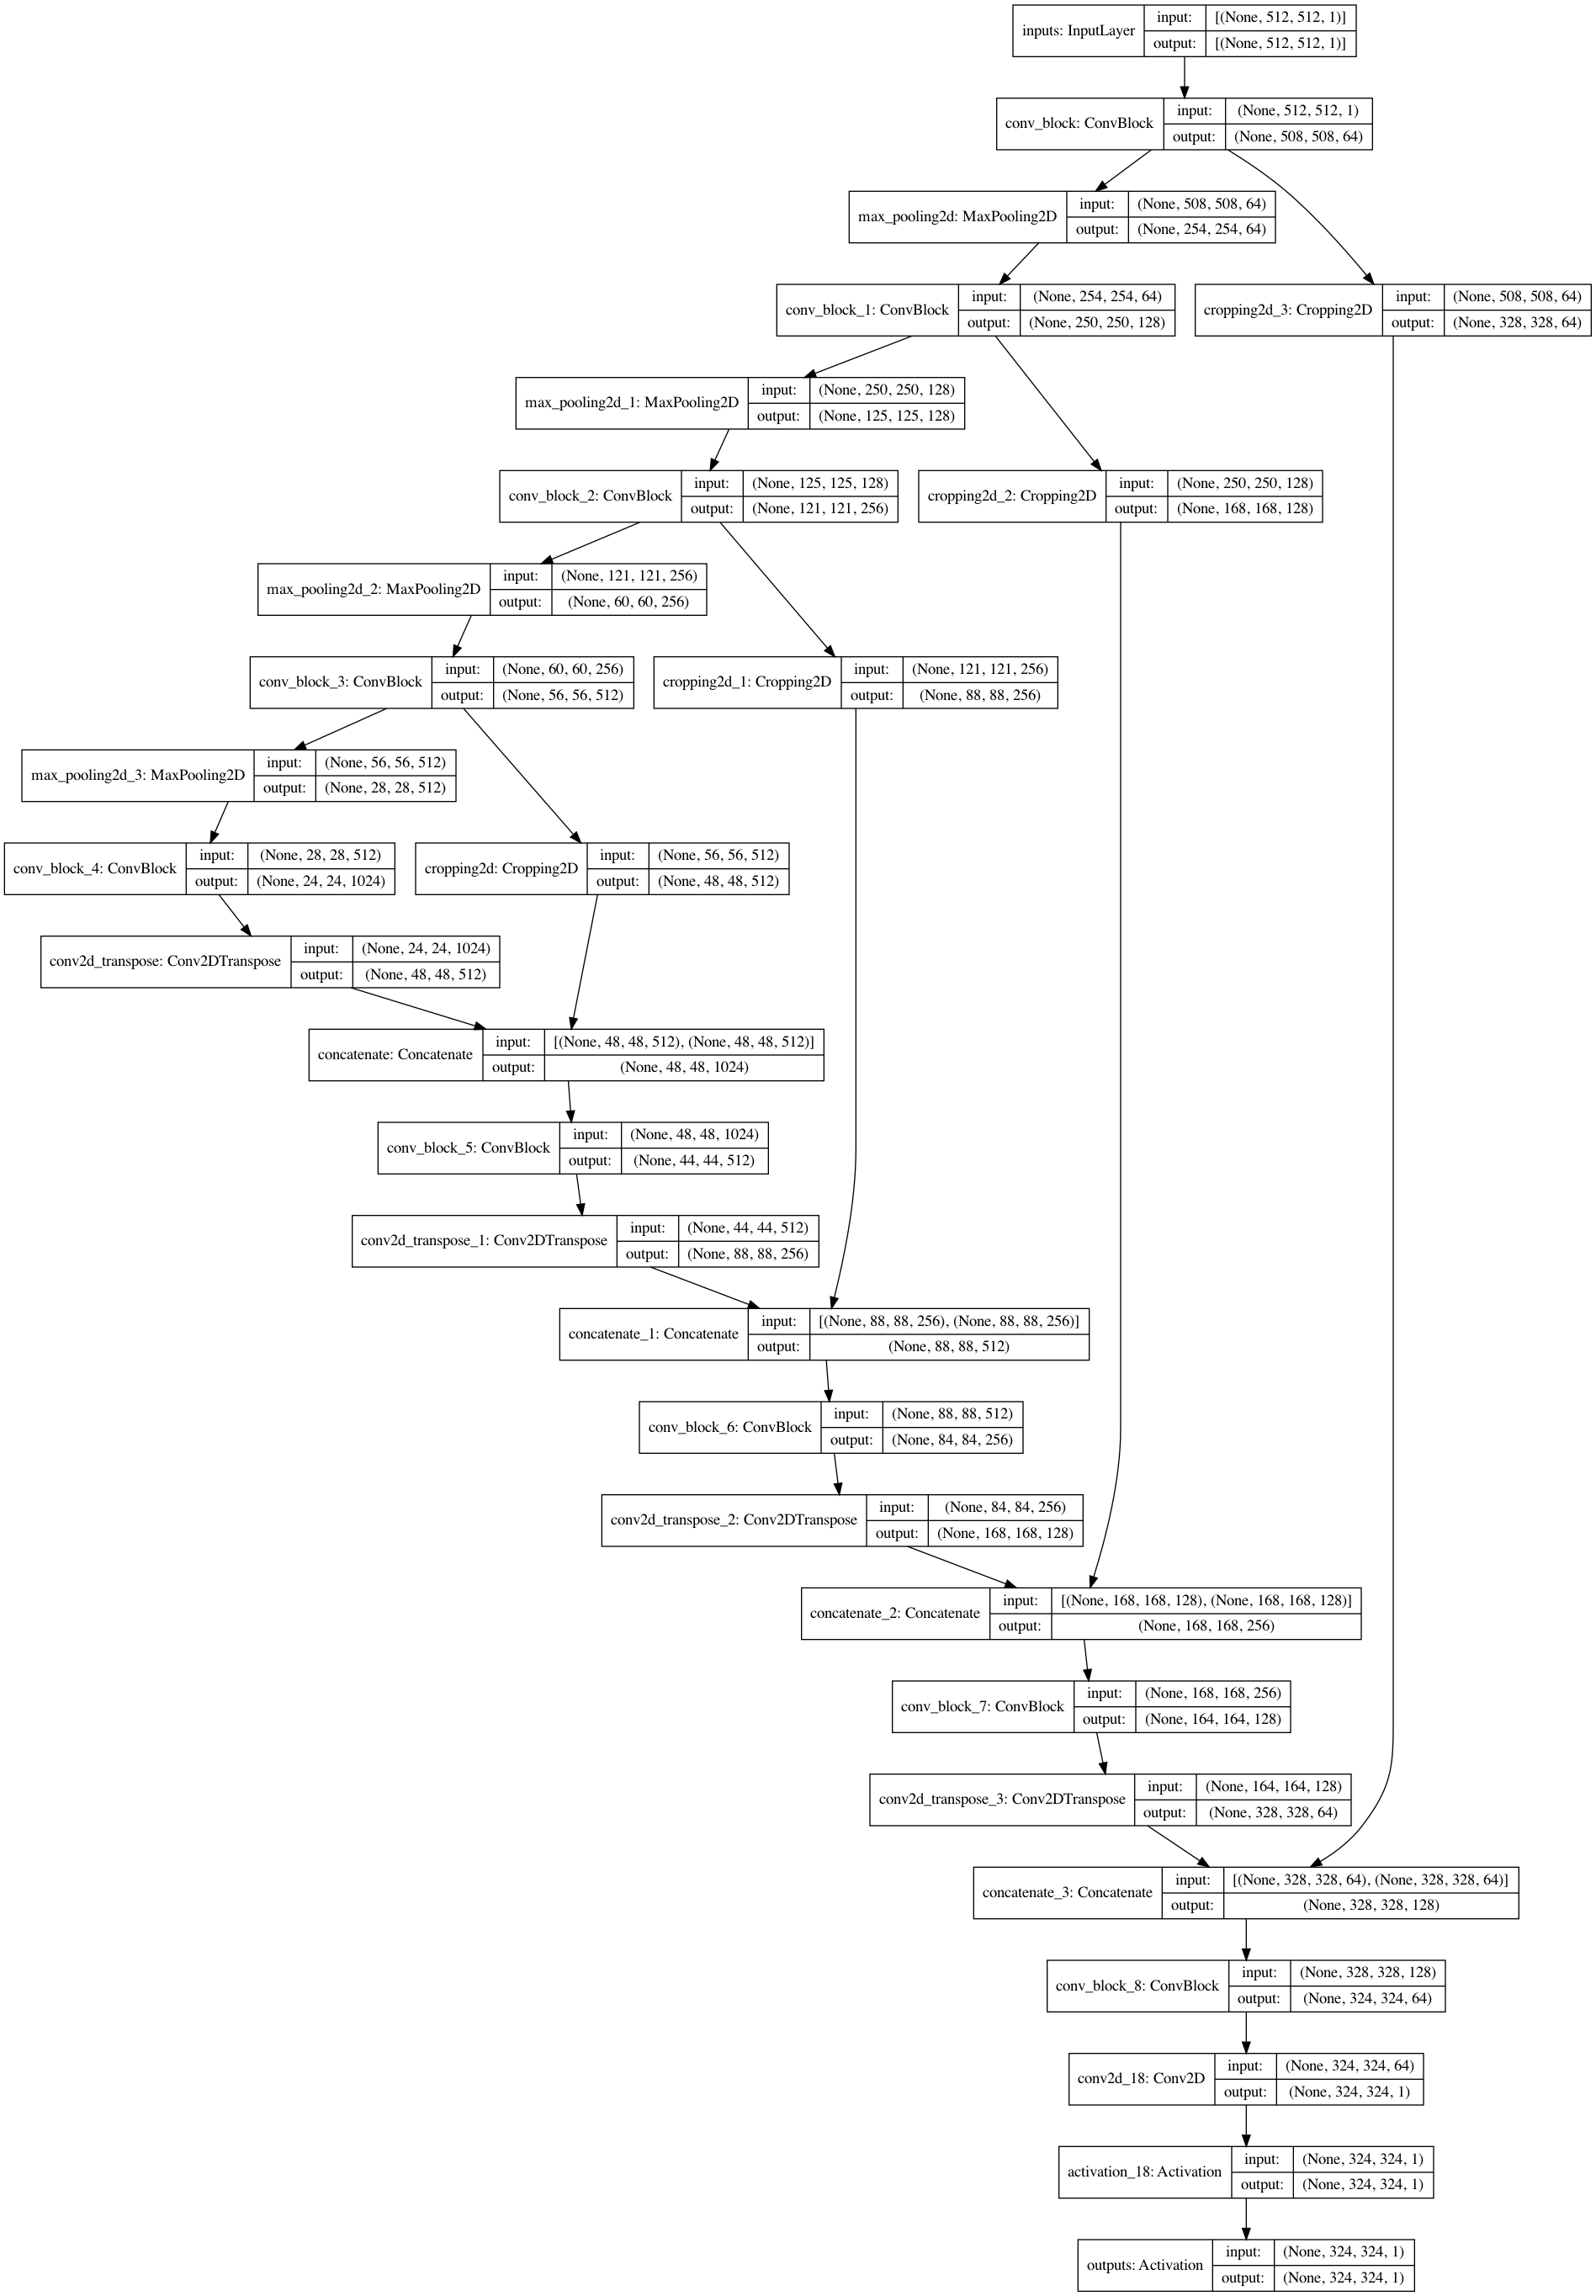

In [15]:
unet.plot(show_shapes = True)

In [ ]:
unet.fit(generator, batch_size = batch_size, verbose = 1)